In [1]:
import sys
import os

pwd = os.getcwd()
python_path = pwd[: pwd.rfind("/")]
sys.path.append(python_path)

In [2]:
import torch
import lightning as pl
import jupyter_black
import segmentation_models_pytorch as smp
import torch.nn as nn
from data import FakeBacteriasDataModule
from models import BacteriasBinarySegmentation
from utils import show_images
from lightning.pytorch.loggers import TensorBoardLogger

jupyter_black.load()
torch.set_float32_matmul_precision("high")

In [14]:
class FPN(pl.LightningModule):
    def __init__(self, lr: float = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.create_model(
            "FPN",
            "resnet34",
            in_channels=1,
            classes=1,
        )

    def configure_optimizers(self):
        lr: float = self.hparams.lr  # type: ignore
        return torch.optim.Adam(self.parameters(), lr=lr, betas=(0.5, 0.99))

    def configure_loss(self, loss_name: str):
        bce_loss = nn.BCELoss()
        jaccard_loss = smp.losses.JaccardLoss(smp.losses.BINARY_MODE, from_logits=True)
        losses = {
            "jaccard": jaccard_loss,
            "bce": bce_loss,
            "jaccard_bce": lambda y_hat, y: jaccard_loss(y_hat, y) + bce_loss(y_hat, y),
        }
        self.loss = losses[loss_name]

    def forward(self, x: torch.Tensor):
        y_hat = self.model(x)
        y_hat = y_hat.sigmoid()
        return y_hat

    def shared_step(self, batch: tuple, batch_idx: int):
        x, y = batch
        assert y.max() <= 1.0 and y.min() >= 0
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        return loss

    def training_step(self, batch: tuple, batch_idx: int):
        loss = self.shared_step(batch, batch_idx)
        self.log_dict({"train_loss": loss}, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        self.log_dict({"test_loss": loss}, prog_bar=True)
        return loss

In [15]:
TRAIN_PARAMS = {"batch_size": 128, "num_workers": 1, "shuffle": True, "limit": 5000}
TEST_PARAMS = {"batch_size": 1, "num_workers": 1, "shuffle": False, "limit": 80}

LR = 0.001
EPOCHS = 20  # 20
LOSS = "jaccard_bce"
VERSION = "jaccard_bce_loss"

fpn = FPN(lr=LR)
fpn.configure_loss(LOSS)
logger = TensorBoardLogger(save_dir="../../logs/fpn", version=VERSION)
datamodule = FakeBacteriasDataModule(train_params=TRAIN_PARAMS, test_params=TEST_PARAMS)

trainer = pl.Trainer(
    max_epochs=EPOCHS, accelerator="gpu", devices=1, logger=logger, log_every_n_steps=10
)
_ = trainer.fit(model=fpn, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FPN  | 23.1 M
-------------------------------
23.1 M    Trainable params
0         Non-trainable params
23.1 M    Total params
92.596    Total estimated model params size (MB)
/opt/conda/envs/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [16]:
_ = trainer.test(model=fpn, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.3197511434555054     │
└───────────────────────────┴───────────────────────────┘

In [24]:
def get_image(tensor: torch.Tensor, label: str):
    return tensor.detach()[0].numpy().squeeze(), label


origs = []
masks = []
preds = []

limit = 5
with torch.no_grad():
    fpn.eval()
    datamodule.setup("test")
    for i, batch in enumerate(datamodule.test_dataloader()):
        x, y = batch
        y_hat = fpn(x)
        origs.append(get_image(x, "orig"))
        masks.append(get_image(y, "mask"))
        preds.append(get_image(y_hat, "pred"))
        if i == limit - 1:
            break

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

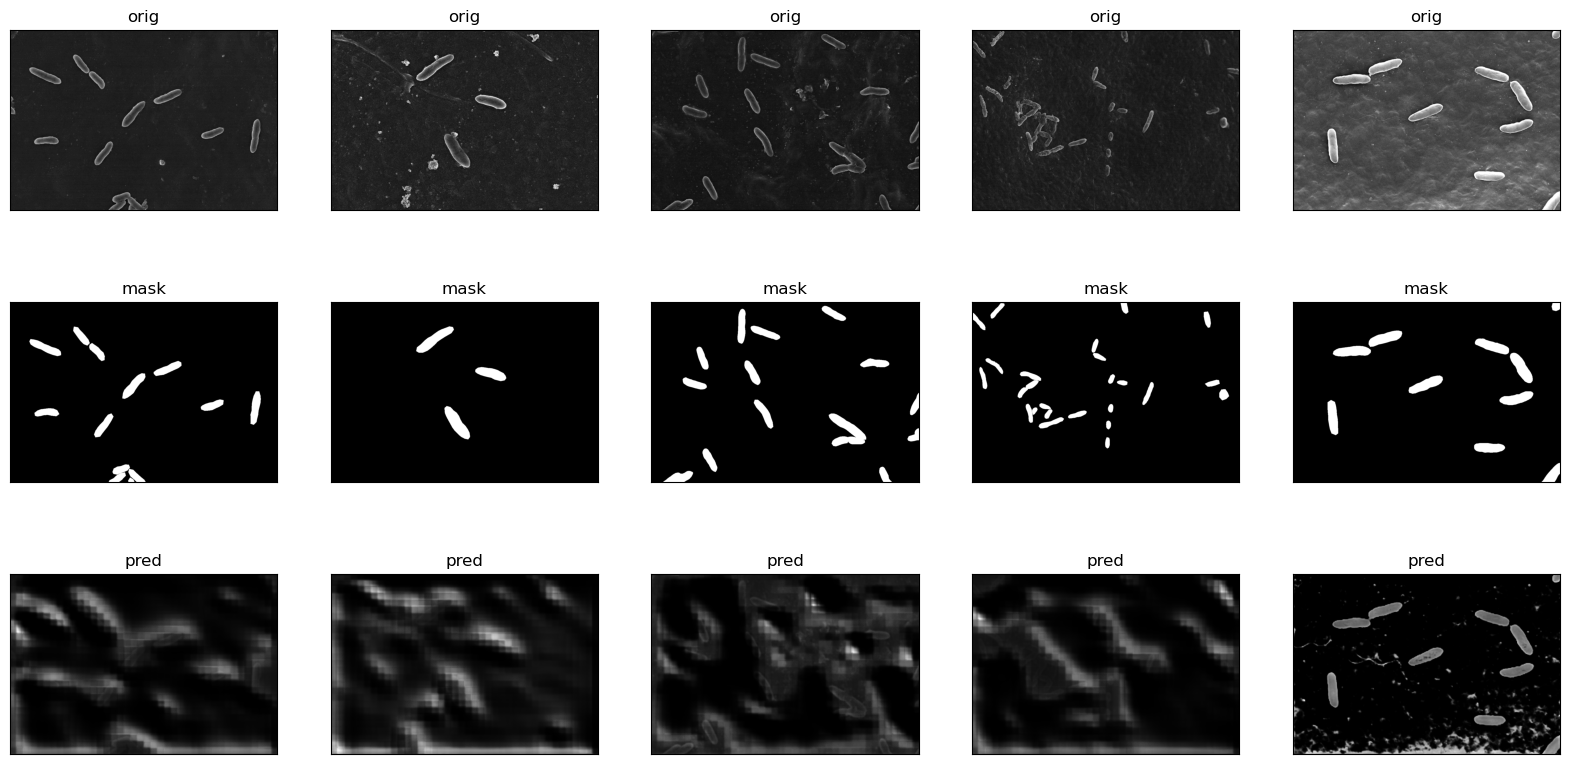

In [25]:
show_images([*origs, *masks, *preds], grid=(3, len(origs)), size_inches=(20, 10))